In [36]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
dataset = pd.read_csv('data/sample_school_level_data.csv')
dataset.head()

,Unnamed: 0,SCHID,AGEC_NEW,SCHTREAT_(1) Treatment school (Roots meetings 2012-2013),GENDER_(1) Boy,GR_(1) 6th grade,GR_(2) 7th grade,GR_(3) 8th grade,COLL_(1) Yes,COLL_(2) Maybe,COLL_(3) Don't know,CELL_(1) Cell phone without Internet,CELL_(2) Cell phone with Internet,FSCH_(1) Do go to this school,composite_conflict_score
0,0,1,12.106618,1.0,0.505415,0.274368,0.324910,0.310469,0.685921,0.126354,0.064982,0.288809,0.458484,0.761733,4.836643
1,1,2,11.666667,0.0,0.478261,0.236295,0.209830,0.272212,0.750473,0.092628,0.047259,0.209830,0.459357,0.727788,5.282609
2,2,3,12.500000,1.0,0.500000,0.000000,0.471014,0.442029,0.782609,0.065217,0.028986,0.202899,0.572464,0.768116,5.021739
3,3,5,12.539130,0.0,0.460870,0.000000,0.460870,0.443478,0.826087,0.034783,0.034783,0.434783,0.356522,0.704348,4.395652
4,4,6,12.529412,1.0,0.449679,0.002141,0.481799,0.466809,0.862955,0.034261,0.027837,0.383298,0.417559,0.813704,5.442184


In [38]:
dataset.columns
dataset =dataset.drop(['Unnamed: 0'],axis=1)


Rename the colunms for parsing causal graph (No number, space and brackets)

In [47]:
dataset = dataset.rename({"SCHTREAT_(1) Treatment school (Roots meetings 2012-2013)": "treatment",
"GENDER_(1) Boy": "boy_ratio",
"GR_(1) 6th grade":"sixth_grade",
"GR_(2) 7th grade":"seventh_grade",
"GR_(3) 8th grade":"eighrth_grade",
"COLL_(1) Yes":"yes_college",
"COLL_(2) Maybe":"maybe_college",
"COLL_(3) Don't know":"not_sure_college",
"CELL_(1) Cell phone without Internet":"no_phone_internet",
"CELL_(2) Cell phone with Internet":"phone_internet",
"FSCH_(1) Do go to this school":"go_this_school"
},axis=1)
dataset.columns

Index(['SCHID', 'AGEC_NEW', 'treatment', 'boy_ratio', 'sixth_grade',
       'seventh_grade', 'eighrth_grade', 'yes_college', 'maybe_college',
       'not_sure_college', 'no_phone_internet', 'phone_internet',
       'go_this_school', 'composite_conflict_score'],
      dtype='object')

## Causal Discovery Using PC Algorithm

Depth=1, working on node 12: 100%|██████████| 13/13 [00:00<00:00, 113.67it/s]


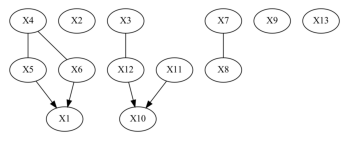

In [40]:
from causallearn.search.ConstraintBased.PC import pc

study_np = dataset.to_numpy()
cg = pc(study_np[:,1:],verbose=False)

# visualization using pydot
cg.draw_pydot_graph()

The result doesn't make sense for our study. Let's build a graph manually.

In [42]:
dataset.columns

Index(['SCHID', 'AGEC_NEW', 'treatment', 'boy_ratio', 'sixth_grade',
       'seventh_grade', 'eighrth_grade', 'yes_college', 'maybe_college',
       'not_sure_college', 'no_phone_internet', 'phone_internet',
       'go_this_school', 'composite_conflict_score'],
      dtype='object')

## Have a look on the correlation between treatment and outcome

In [88]:
# Have a look on the average effect

d0 = dataset[dataset.treatment == 0]
d0m = d0['composite_conflict_score'].mean()
print('Without treatment, the conflict level score is',d0m)

d1 = dataset[dataset.treatment == 1]
d1m = d1['composite_conflict_score'].mean()
print('With treatment, the conflict level score is',d1m)

Without treatment, the conflict level score is 4.9586868886381925
With treatment, the conflict level score is 5.093505706785584


Our causal graph logic is:
1. Age may cause the grade, go to college decision, phone internet rate, go this school and conflict level
2. Boy ratio may cause the college decisioin and conflict level
3. Grades cause affect other and affect go to college decision, phone internet rate, go this school and conflict level
4. College decision affect each other and conflict score
5. Internet may affect the conflict level
6. Go to this school affect the satisification of the school thus conflict level.



In [57]:
# This is a graph with circle, we should move later.
causal_graph = '''digraph{
    AGEC_NEW[label="Age"];
    treatment[label="Treatment"];
    boy_ratio[label="Boy Percentage"];
    sixth_grade[label="6th Grade Ratio"];
    seventh_grade[label="7th Grade Ratio"];
    eighth_grade[label="8th Grade Ratio"];
    yes_college[label="Go College Ratio"];
    maybe_college[label="Maybe Go College Ratio"];
    not_sure_college[label="Don't Know Go College Ratio"];
    no_phone_internet[label="Cell Phone Without Internet"];
    phone_internet[label="Cell Phone With Internet"];
    go_this_school[label="Do Go To This School Ratio"];
    composite_conflict_score[label="Composite Conflict Score"];
    treatment-> composite_conflict_score;
    AGEC_NEW -> {sixth_grade,seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, composite_conflict_score};
    boy_ratio -> {yes_college,maybe_college,not_sure_college,composite_conflict_score};
    sixth_grade -> {seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, composite_conflict_score};
    seventh_grade -> {sixth_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, composite_conflict_score};
    eighth_grade -> {sixth_grade,seventh_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, composite_conflict_score};
    yes_college -> {maybe_college,not_sure_college,composite_conflict_score};
    maybe_college -> {yes_college,not_sure_college,composite_conflict_score};
    not_sure_college -> {maybe_college,maybe_college,composite_conflict_score};
    no_phone_internet -> {phone_internet, composite_conflict_score};
    phone_internet -> {no_phone_internet, composite_conflict_score};
    go_this_school-> composite_conflict_score;
}

'''

In [79]:
causal_graph = '''digraph{
    AGEC_NEW[label="Age"];
    treatment[label="Treatment"];
    boy_ratio[label="Boy Percentage"];
    sixth_grade[label="6th Grade Ratio"];
    seventh_grade[label="7th Grade Ratio"];
    eighth_grade[label="8th Grade Ratio"];
    yes_college[label="Go College Ratio"];
    maybe_college[label="Maybe Go College Ratio"];
    not_sure_college[label="Don't Know Go College Ratio"];
    phone_internet[label="Cell Phone With Internet"];
    go_this_school[label="Do Go To This School Ratio"];
    composite_conflict_score[label="Composite Conflict Score"];
    U[label="Unobserved Confounders"];
    treatment-> composite_conflict_score;
    AGEC_NEW -> {sixth_grade,seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, composite_conflict_score};
    boy_ratio -> {yes_college,maybe_college,not_sure_college,composite_conflict_score};
    sixth_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, composite_conflict_score};
    seventh_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, composite_conflict_score};
    eighth_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, composite_conflict_score};
    yes_college -> {composite_conflict_score};
    maybe_college -> {composite_conflict_score};
    not_sure_college -> {composite_conflict_score};
    phone_internet -> {no_phone_internet, composite_conflict_score};
    go_this_school-> composite_conflict_score;
}

'''

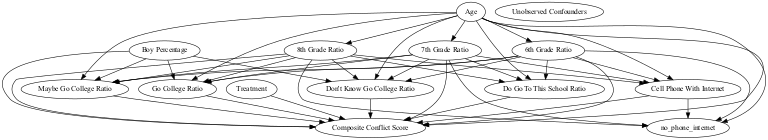

In [81]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='treatment',
        outcome='composite_conflict_score')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Identify the causal effect

In [82]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                             
────────────(Expectation(composite_conflict_score))
d[treatment]                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→composite_conflict_score then P(composite_conflict_score|treatment,,U) = P(composite_conflict_score|treatment,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear regression for backdoor estimator

In [71]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                             
────────────(Expectation(composite_conflict_score))
d[treatment]                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→composite_conflict_score then P(composite_conflict_score|treatment,,U) = P(composite_conflict_score|treatment,)

## Realized estimand
b: composite_conflict_score~treatment+treatment*not_sure_college+treatment*maybe_college+treatment*AGEC_NEW+treatment*go_this_school+treatment*boy_ratio+treatment*sixth_grade+treatment*phone_internet+treatment*seventh_grade+treatment*yes_college
Target units: ate

## Estimate
Mean value: 0.16068057256651347
### Conditional Estimates
__categorical__not_sure_college  __categorical__maybe_college    __categorical__AGEC_NEW  __categorical__go_this_school  __categorical__boy_ratio  __categorical__sixth

In [67]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:0.16068057256651347
New effect:0.15787906831254409
p value:0.43000000000000005



In [68]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered

Refute: Use a Placebo Treatment
Estimated effect:0.16068057256651347
New effect:0.0
p value:1.0



In [69]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.16068057256651347
New effect:0.16694125468311985
p value:0.47



## Double Machine Learning Method (Under debugging)

In [78]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import econml


In [77]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = "ate",
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

ImportError: Error loading econml.dml.DML. Double-check the method name and ensure that all econml dependencies are installed.